In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def open_hdf5(file_path):
    """ Open an HDF5 file and return the file object. """
    return h5py.File(file_path, 'r')

# hdf5_path = r"/Users/cadenmyers/billingelab/dev/sym_adapted_filts/data/SkL_data/Instrument_Appended_September_extracted_data.h5"
# hdf5_file = open_hdf5(hdf5_path)

In [4]:
def get_data_for_ml(hdf5_file, numor_ids):
    """ Extract data and metadata for ML/AI applications for one or multiple numors. """
    all_data = {}
    
    # Ensure numor_ids is a list for single and multiple numor handling
    if not isinstance(numor_ids, list):
        numor_ids = [numor_ids]
    
    for numor_id in numor_ids:
        group = hdf5_file[f'Numor{numor_id}']
        data = {
            'q_x': group['q_x (inverse angstrom)'][:],
            'q_y': group['q_y (inverse angstrom)'][:],
            'intensity': group['intensity (counts per standard monitor)'][:],
            'intensity_err': group['intensity_err (counts per standard monitor)'][:]
        }
        
        # Retrieve and include metadata in the dictionary
        metadata = {attr: group.attrs[attr] for attr in group.attrs}
        data.update(metadata)
        
        # Store data for this numor keyed by its ID
        all_data[numor_id] = data
    
    return all_data



In [5]:
from scipy.ndimage import gaussian_filter

def mask_and_blur_images(array):
    '''masks signal inside radius of 14 and outside radius of 30 and adds gaussian blur for all intensity data'''
    x,y = np.meshgrid(np.arange(128), np.arange(128))
    radius = np.sqrt((x-64)**2 + (y-62)**2)
    mask1 = radius <= 14
    mask2 = radius >= 30
    masked_data = array.copy()
    masked_data[mask1] = 0
    masked_data2 = masked_data.copy()
    masked_data2[mask2] = 0
    # masked_data_norm = (masked_data - np.min(masked_data) / (np.max(masked_data) - np.min(masked_data)))
    # blurred_data = gaussian_filter(masked_data2, sigma=.65)
    array = masked_data2
    return array



In [7]:
import os
import numpy as np


start_numor = 56358
end_numor = start_numor + 299
numors = list(np.arange(start_numor, end_numor))

def save_stack_of_images(file_name, directory_name='/Users/cadenmyers/billingelab/dev/sym_adapted_filts/data/SkL_data/masked_npz_data/'):
    '''This function saves the stack of images (128,128,len(numors)) as <file_name> under <directory_name>'''
    all_data = []

    if os.path.exists(file_name):
        print(f"File '{file_name}' already exists. Skipping save.")
        return

    for numor in numors:
        numor_data = get_data_for_ml(hdf5_file, numor)
        numor_dict = numor_data[numor]

        data = mask_and_blur_images(numor_dict.get('intensity'))
        all_data.append(data)  # Append each image data to the list

    # Stack all images along a new axis to create an array of shape (X, 128, 128)
    all_data_array = np.stack(all_data, axis=0)
    print("Data shape:", all_data_array.shape)

    # Save all images into a single .npz file
    np.savez(directory_name+file_name, data=all_data_array)

    return

direction = 'neg'
B = '35'
B_field = B + 'mT_'
power = '50mW'
Temp = '553_'

print(end_numor+1 - start_numor)
print(direction + B_field + Temp + power)
# save_stack_of_images(str(start_numor))

300
neg35mT_553_50mW


Loaded NPZ file shape: (299, 128, 128)
Loaded unmasked NPZ file shape: (299, 128, 128)


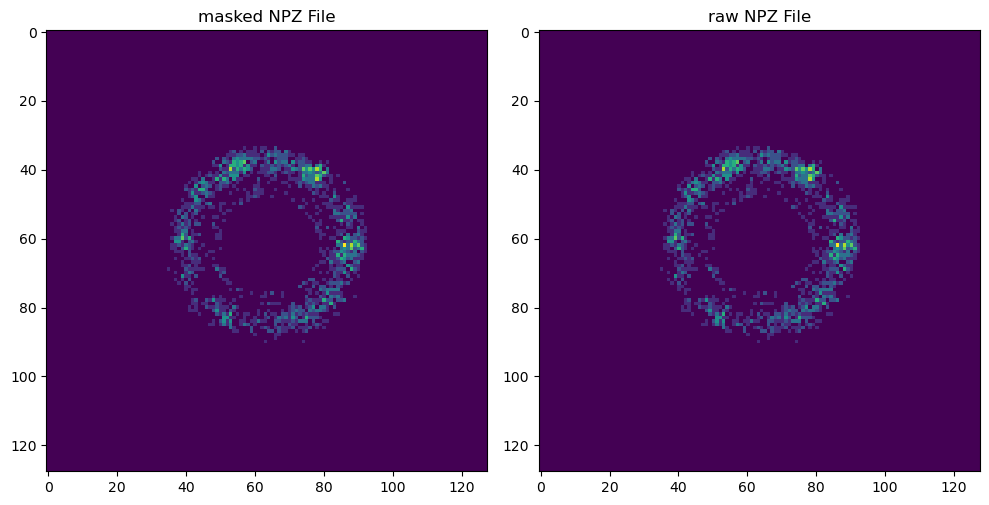

In [8]:
# test the loaded file
masked_npz_file = np.load(f'/Users/cadenmyers/billingelab/dev/sym_adapted_filts/data/SkL_data/masked_npz_data/{start_numor}.npz')['data']
raw_npz_file = np.load(f'/Users/cadenmyers/billingelab/dev/sym_adapted_filts/data/SkL_data/npz_sept_numor_data/{start_numor}.npz')['data']
print("Loaded NPZ file shape:", masked_npz_file.shape)
print("Loaded unmasked NPZ file shape:", raw_npz_file.shape)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(masked_npz_file[0])
axes[0].set_title('masked NPZ File')
axes[1].imshow(mask_and_blur_images(raw_npz_file[0]))
axes[1].set_title('raw NPZ File')
plt.tight_layout()


In [ ]:
import os

def save_individual_images(directory_name):
    '''This function saves each image in `numors` as `image_<numor>.npz` to the specified input directory name'''
    directory = directory_name

    if os.path.exists(directory_name):
        print(f"Directory '{directory_name}' already exists. Skipping save.")
        return

    for numor in numors:
        numor_data = get_data_for_ml(hdf5_file, numor)
        numor_dict = numor_data[numor]

        qx = numor_dict.get('q_x')
        qy = numor_dict.get('q_y')
        int = mask_and_blur_images(numor_dict.get('intensity'))
        data = np.stack([qx, qy, int], axis=0)

        if not os.path.exists(directory):
            os.makedirs(directory)

        np.savez(os.path.join(directory, f'image_{numor}.npz'), data=data)
    return

